In [2]:
# EEG Data Analysis Notebook

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, welch
import seaborn as sns
from datetime import datetime

# Set plot aesthetics
sns.set(style='whitegrid')
%matplotlib inline

# Define file paths
eeg_file = 'work/eeg_data.csv'
log_file = 'work/baseline_log.csv'

# Load EEG data
eeg_df = pd.read_csv(eeg_file, parse_dates=['timestamp'])
print(f"EEG data loaded: {eeg_df.shape[0]} samples")

# Load event log
log_df = pd.read_csv(log_file, parse_dates=['timestamp'])
print(f"Event log loaded: {log_df.shape[0]} events")

# Display first few rows of EEG data
eeg_df.head()


EEG data loaded: 1190 samples
Event log loaded: 6 events


,timestamp,ch1,ch2
0,2025-05-15 07:06:06.535,712,269
1,2025-05-15 07:06:06.535,591,27
2,2025-05-15 07:06:06.535,360,850
3,2025-05-15 07:06:06.535,333,1023
4,2025-05-15 07:06:06.535,552,1023


In [3]:
# Define a bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

# Sampling frequency (Hz)
fs = 256  # Adjust based on your device's sampling rate

# Apply bandpass filter to both channels
eeg_df['ch1_filtered'] = bandpass_filter(eeg_df['ch1'], 1, 40, fs)
eeg_df['ch2_filtered'] = bandpass_filter(eeg_df['ch2'], 1, 40, fs)


In [4]:
# Extract baseline start and end times
baseline_start = log_df[log_df['event'] == 'baseline_start']['timestamp'].values[0]
baseline_end = log_df[log_df['event'] == 'baseline_end']['timestamp'].values[0]

# Extract voice event start and end times
voice_events = []
starts = log_df[log_df['event'] == 'voice_event_start']['timestamp'].reset_index(drop=True)
ends = log_df[log_df['event'] == 'voice_event_end']['timestamp'].reset_index(drop=True)

# Ensure equal number of starts and ends
for start, end in zip(starts, ends):
    voice_events.append((start, end))

# Display event times
print(f"Baseline: {baseline_start} to {baseline_end}")
for i, (start, end) in enumerate(voice_events):
    print(f"Voice Event {i+1}: {start} to {end}")


Baseline: 2025-05-15T07:06:06.535000000 to 2025-05-15T07:06:11.124000000
Voice Event 1: 2025-05-15 07:06:07.990000 to 2025-05-15 07:06:08.706000
Voice Event 2: 2025-05-15 07:06:10.160000 to 2025-05-15 07:06:10.684000


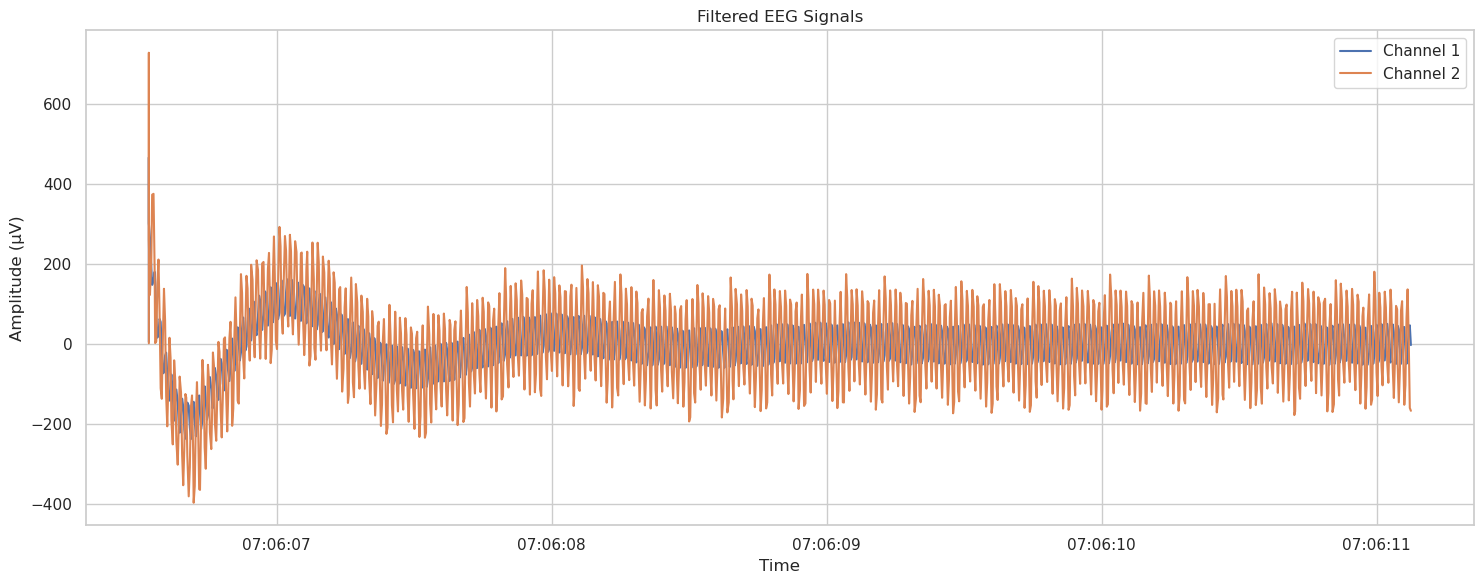

In [5]:
# Plot filtered EEG signals
plt.figure(figsize=(15, 6))
plt.plot(eeg_df['timestamp'], eeg_df['ch1_filtered'], label='Channel 1')
plt.plot(eeg_df['timestamp'], eeg_df['ch2_filtered'], label='Channel 2')
plt.xlabel('Time')
plt.ylabel('Amplitude (μV)')
plt.title('Filtered EEG Signals')
plt.legend()
plt.tight_layout()
plt.show()


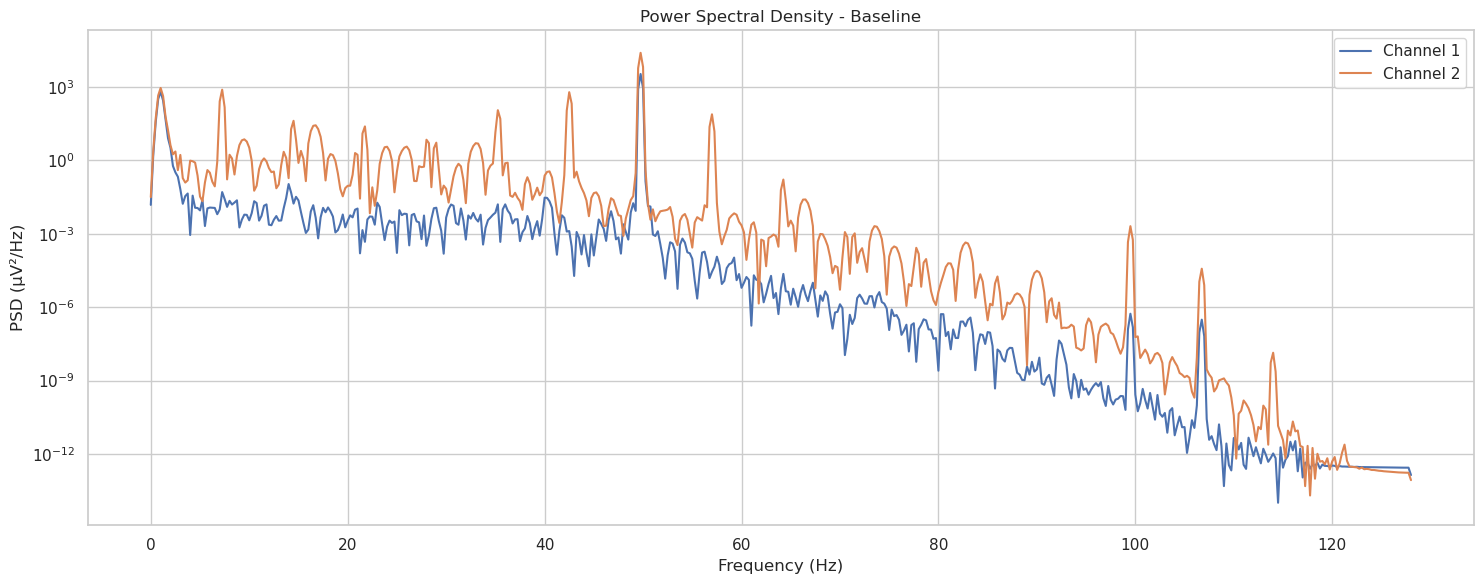

,Channel 1,Channel 2
Delta,330.830175,475.485921
Theta,0.064431,298.400036
Alpha,0.047805,9.257639
Beta,0.141354,70.611242
Gamma,0.079670,285.307926


In [6]:
# Define a function to compute PSD
def compute_psd(data, fs):
    freqs, psd = welch(data, fs, nperseg=1024)
    return freqs, psd

# Compute PSD for baseline period
baseline_data = eeg_df[(eeg_df['timestamp'] >= baseline_start) & (eeg_df['timestamp'] <= baseline_end)]
freqs, psd_ch1 = compute_psd(baseline_data['ch1_filtered'], fs)
_, psd_ch2 = compute_psd(baseline_data['ch2_filtered'], fs)

# Plot PSD
plt.figure(figsize=(15, 6))
plt.semilogy(freqs, psd_ch1, label='Channel 1')
plt.semilogy(freqs, psd_ch2, label='Channel 2')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (μV²/Hz)')
plt.title('Power Spectral Density - Baseline')
plt.legend()
plt.tight_layout()
plt.show()
# Define frequency bands
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 45)
}

# Function to calculate band power
def bandpower(psd, freqs, band):
    low, high = band
    idx = np.logical_and(freqs >= low, freqs <= high)
    return np.trapz(psd[idx], freqs[idx])

# Calculate band powers for baseline
band_powers = {}
for band_name, band_range in bands.items():
    power_ch1 = bandpower(psd_ch1, freqs, band_range)
    power_ch2 = bandpower(psd_ch2, freqs, band_range)
    band_powers[band_name] = {'Channel 1': power_ch1, 'Channel 2': power_ch2}

# Display band powers
band_powers_df = pd.DataFrame(band_powers).T
band_powers_df


/opt/conda/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 185, using nperseg = 185
  warnings.warn('nperseg = {0:d} is greater than input length '


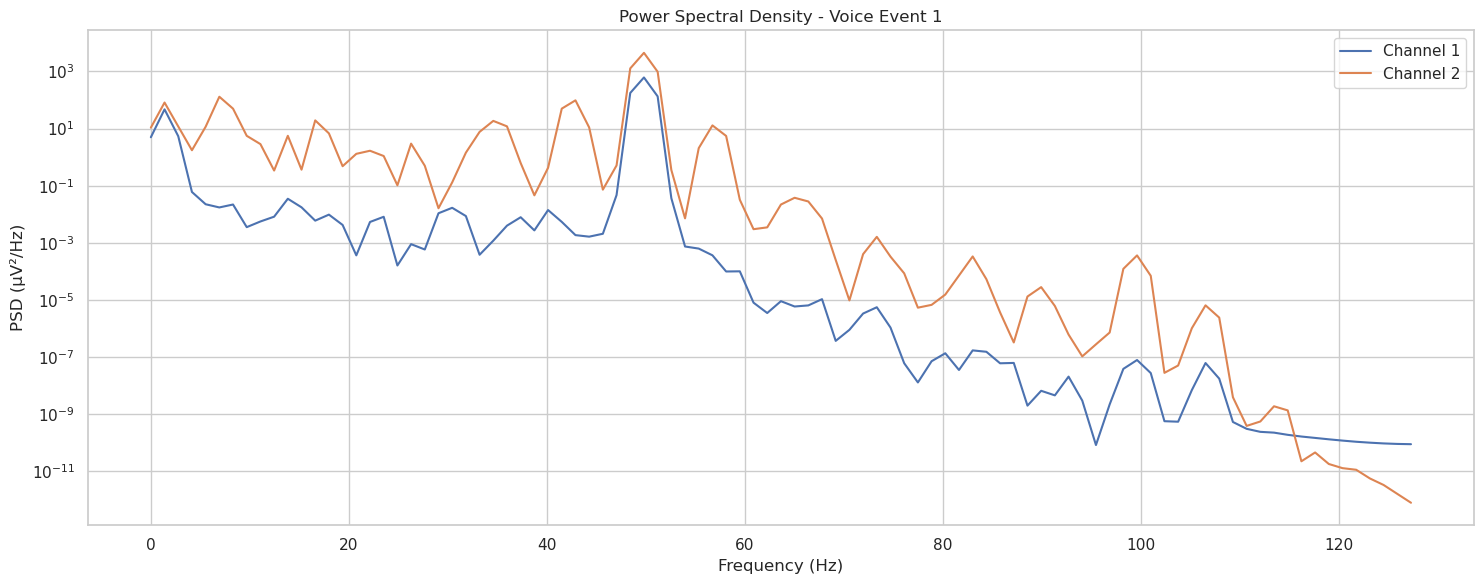

/opt/conda/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 135, using nperseg = 135
  warnings.warn('nperseg = {0:d} is greater than input length '


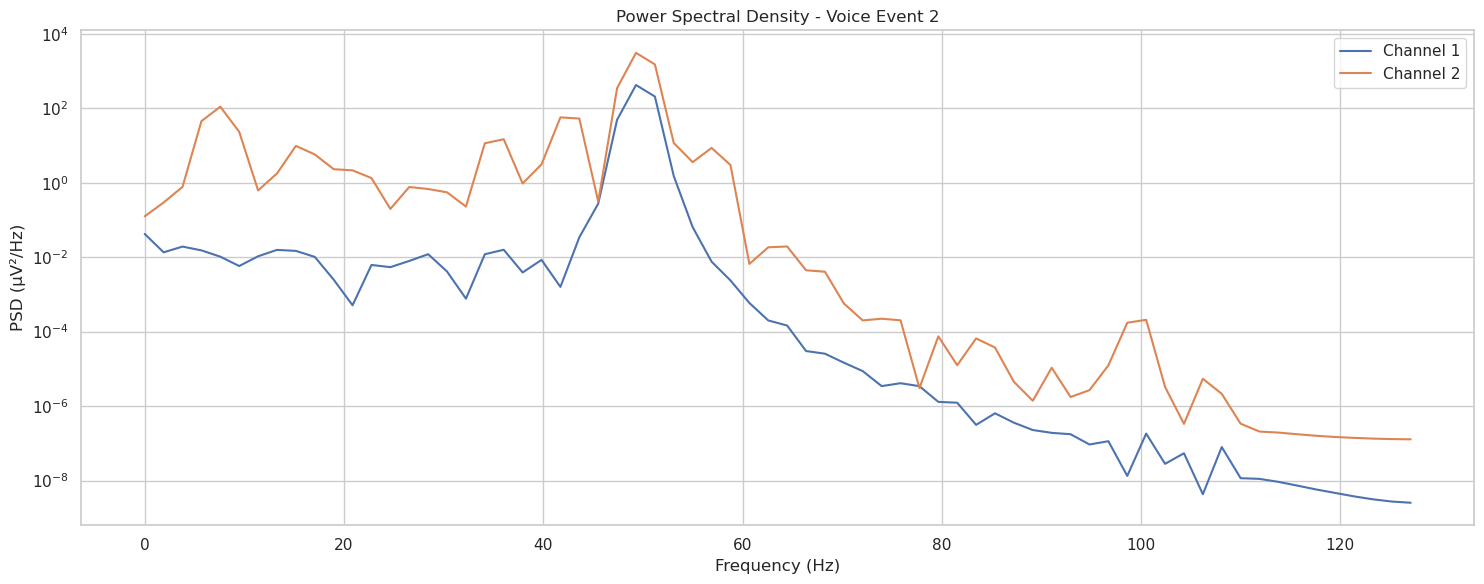

In [7]:
# Analyze each voice event
for i, (start, end) in enumerate(voice_events):
    event_data = eeg_df[(eeg_df['timestamp'] >= start) & (eeg_df['timestamp'] <= end)]
    freqs, psd_ch1 = compute_psd(event_data['ch1_filtered'], fs)
    _, psd_ch2 = compute_psd(event_data['ch2_filtered'], fs)
    
    # Plot PSD for voice event
    plt.figure(figsize=(15, 6))
    plt.semilogy(freqs, psd_ch1, label='Channel 1')
    plt.semilogy(freqs, psd_ch2, label='Channel 2')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (μV²/Hz)')
    plt.title(f'Power Spectral Density - Voice Event {i+1}')
    plt.legend()
    plt.tight_layout()
    plt.show()